In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score

nltk.download('stopwords')

stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data

In [2]:
#Read in the data
review = pd.read_csv("Womens Clothing E-Commerce Reviews.csv", index_col = 0)

In [3]:
#format the column names
review.columns = review.columns.str.lower().str.replace(' ', '_')

In [4]:
display(review.head())

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
display(review.shape)

(23486, 10)

In [6]:

display(review.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   clothing_id              23486 non-null  int64 
 1   age                      23486 non-null  int64 
 2   title                    19676 non-null  object
 3   review_text              22641 non-null  object
 4   rating                   23486 non-null  int64 
 5   recommended_ind          23486 non-null  int64 
 6   positive_feedback_count  23486 non-null  int64 
 7   division_name            23472 non-null  object
 8   department_name          23472 non-null  object
 9   class_name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


None

In [7]:
review.describe(include = 'all')

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name
count,23486.000000,23486.000000,19676,22641,23486.000000,23486.000000,23486.000000,23472,23472,23472
unique,NaN,NaN,13993,22634,NaN,NaN,NaN,3,6,20
top,NaN,NaN,Love it!,Perfect fit and i've gotten so many compliment...,NaN,NaN,NaN,General,Tops,Dresses
freq,NaN,NaN,136,3,NaN,NaN,NaN,13850,10468,6319
mean,918.118709,43.198544,NaN,NaN,4.196032,0.822362,2.535936,NaN,NaN,NaN
std,203.298980,12.279544,NaN,NaN,1.110031,0.382216,5.702202,NaN,NaN,NaN
min,0.000000,18.000000,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN
25%,861.000000,34.000000,NaN,NaN,4.000000,1.000000,0.000000,NaN,NaN,NaN
50%,936.000000,41.000000,NaN,NaN,5.000000,1.000000,1.000000,NaN,NaN,NaN
75%,1078.000000,52.000000,NaN,NaN,5.000000,1.000000,3.000000,NaN,NaN,NaN


In [8]:
#Get the index of rows with null review_text
row_index = review[review.review_text.isnull()].index.values

#Drop the 845 rows with missing text
review_df = review.drop(row_index, axis = 0).reset_index()
review_df.shape

(22641, 11)

In [9]:
review_df.isnull().sum()

index                         0
clothing_id                   0
age                           0
title                      2966
review_text                   0
rating                        0
recommended_ind               0
positive_feedback_count       0
division_name                13
department_name              13
class_name                   13
dtype: int64

# Data Preprocessing using Natural Language Processing


In [10]:
ps = PorterStemmer()
stemmed_words = []
for i in range(len(review_df['review_text'])):
    review_text = re.sub('[^a-zA-Z]', ' ', review_df['review_text'][i])
    review_text = review_text.lower()
    review_text = review_text.split()
    #Remove stop words and stemming
    review_text = [ps.stem(word) for word in review_text if not word in stopword_list]
    review_text = ' '.join(review_text)
    stemmed_words.append(review_text)

In [11]:
display(review_df[(review_df.rating == 1) & (review_df.recommended_ind == 1)].head(3))
review_df[(review_df.rating == 5) & (review_df.recommended_ind == 0)].head(3)

,index,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name
2344,2427,939,39,NaN,Beautiful jacket and i got lots of compliments...,1,1,0,General,Tops,Sweaters
2777,2872,829,51,NaN,Very cute top. i went down a size because for ...,1,1,1,General Petite,Tops,Blouses
5370,5570,861,69,Great t,I love this t-shirt because it has the combina...,1,1,0,General,Tops,Knits


,index,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name
1285,1333,836,25,"Cute shirt, but not for me",The blue lace with the white top underneath is...,5,0,0,General,Tops,Blouses
3375,3499,872,52,Love this top!,This top is one of my retailer faves! it is so...,5,0,2,General,Tops,Knits
3728,3863,1081,53,Love this dress,"I also have this dress in 3/4 sleeve, tegan tu...",5,0,0,General Petite,Dresses,Dresses


In [12]:
#function to create sentiment label
def sentiment_label(row):
    if row['rating'] > 3:
        val = 1
    elif (row['rating'] <= 3) & (row['rating'] == 1):
        val = 1
    else:
        val = 0
    return val

#Create a sentiment column
review_df['sentiment'] = review_df.apply(sentiment_label, axis = 1)

review_df.head(3)

,index,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name,sentiment
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,1
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,1
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0


# Data Visualization

In [13]:
review.dtypes

clothing_id                 int64
age                         int64
title                      object
review_text                object
rating                      int64
recommended_ind             int64
positive_feedback_count     int64
division_name              object
department_name            object
class_name                 object
dtype: object

In [14]:
review = review[['review_text', 'recommended_ind']]
review.head()

,review_text,recommended_ind
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


Text(0.5, 1.0, 'Proportion Target Class')

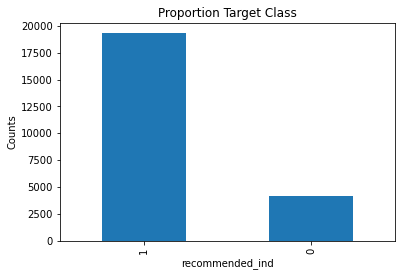

In [15]:
review["recommended_ind"].value_counts().plot(kind='bar')
plt.xlabel("recommended_ind")
plt.ylabel("Counts")
plt.title("Proportion Target Class")

In [16]:

review = review_df.rename(columns={"recommended_ind": "Recommended", "review_text": "Review"})


positive = review[review.Recommended == 1]
negative = review[review.Recommended == 0]
positive.head()

,index,clothing_id,age,title,Review,rating,Recommended,positive_feedback_count,division_name,department_name,class_name,sentiment
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,1
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,1
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,1
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,1
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,1


In [17]:
positive_words =[]

for review in positive.Review:
    positive_words.append(review) 
positive_words = ' '.join(positive_words)
positive_words[:48]

'Absolutely wonderful - silky and sexy and comfor'

In [18]:
negative_words = []

for review in negative.Review:
    negative_words.append(review)
negative_words = ' '.join(negative_words)
negative_words[:455]

'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net ov'

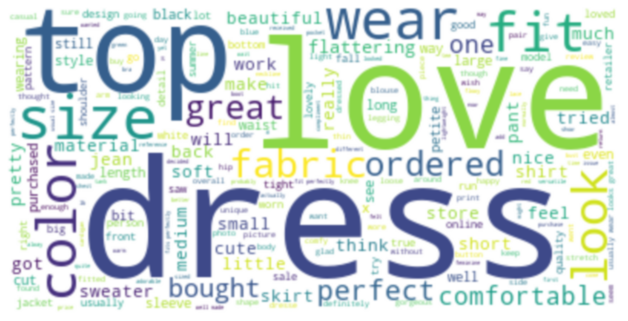

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=len(positive_words))

wordcloud.generate(positive_words)

plt.figure(figsize=(11,11))
plt.imshow(wordcloud, interpolation="bicubic")
plt.axis("off")
plt.show()

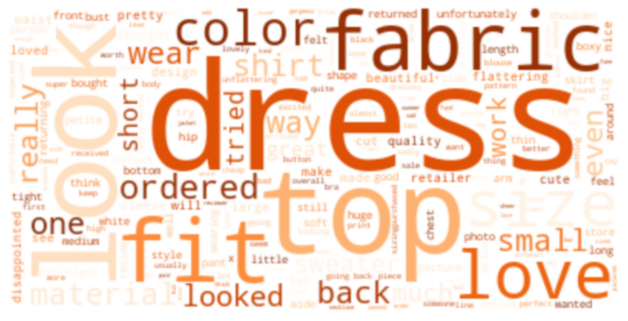

In [20]:
wordcloud = WordCloud(background_color="white", max_words=len(negative_words), colormap='Oranges')

wordcloud.generate(negative_words)

plt.figure(figsize=(11,11))
plt.imshow(wordcloud, interpolation="bicubic")
plt.axis("off")
plt.show()

# Machine Learning Algorithms



## *1. Logistic Regression*

In [21]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(stemmed_words)
y = review_df.copy().sentiment

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
lr = LogisticRegression()
lr.fit(X_train, y_train)

E:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
prediction = lr.predict(X_test)
print(accuracy_score(y_test, prediction))

0.8480833774951422


In [24]:
f1_score(y_test, prediction)

0.9089561719246241

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [28]:
matrix = confusion_matrix(y_test, prediction)
print (matrix)

[[ 508  540]
 [ 320 4293]]


In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

## *2. Naive Bayes Algorithm*

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
NB = MultinomialNB()
NB.fit(X_train, y_train)

MultinomialNB()

In [32]:
prediction1 = NB.predict(X_test)
print(accuracy_score(y_test, prediction))

0.8480833774951422


In [33]:
f1_score(y_test, prediction1)

0.9051987767584099

In [34]:
matrix = confusion_matrix(y_test, prediction1)
print (matrix)

[[ 649  399]
 [ 469 4144]]


## *3. Comparision*

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [35]:
log_acc = accuracy_score(prediction, y_test)
nb_acc = accuracy_score(prediction1, y_test)
log_f1 = f1_score(prediction, y_test)
nb_f1 = f1_score(prediction1, y_test)


models = pd.DataFrame({
                      'Model Name': ['Logistic Regression', 'Naive Bayes'],
                      'Accuracy': [log_acc, nb_acc], 
                      'F1-Score': [log_f1, nb_f1]})
models.sort_values(by='F1-Score', ascending=False)

,Model Name,Accuracy,F1-Score
0,Logistic Regression,0.848083,0.908956
1,Naive Bayes,0.846670,0.905199
